# <center> Are Haters Just Hating? A Statistical Analysis of CS:GO Pro Gamers
<center> Sam Felsenfeld, Cindy Jia, Mark Levin </center>

## <center> Introduction
### What is Counterstrike: Global Offensive?
Counterstrike: Global Offensive - or CS:GO for short - is a multiplayer first-person shooter game with millions of active players. In a game of CS:GO, players compete to kill the opposing team in a virtual shootout while trying to complete objectives like planting or defusing a bomb. While the game itself is fairly competitive, it also boasts a large professional scene where the top players compete in five person teams to be the best in the world. Major tournaments take place almost every week, leading to a constant trove of player data and game statistics.

<br>

#### Player skill
While there is often a clear consensus of which teams are the best during a given time period, the individual skill of players within these teams is often hard to connect to actual team performance: for example a team which has the consensus best player in the world at the time, Vitality, is currently ranked second behind Heroic, a team which has only a single player in the top 20 players of 2022. In a game like CS:GO, an individual's performance is often the deciding factor between winning and losing a match. When star players have slumps, there often seems to be a clear impact on team performance, leading to much criticism from the public.



Public opinion can often be a misrepresentation of the actual performance of public figures. In this analysis, we aim to determine whether the public perception that a player is either at the top of their game or on their way out is actually reality, or just something that people like to overemphasize.

## <center> Data Collection
In order to perform our analysis, we will pull data from 3 different sources.  First will be the raw player data itself. The only source that keeps player level statistics for all CS:GO pro games is hltv.org, a forum devoted to following the game. Information about hltv can be found here: <a href=https://www.hltv.org/stats>hltv.org</a>
The second data source we will be looking at is team ranking over time from esl.tv, a website devoted to ranking teams based on tournament wins. Each day the ESL API is updated with team rankings, making it extremely easy to scrape. Rankings are stored at: <a href=https://pro.eslgaming.com/worldranking/csgo/rankingshistory/>eslgaming.com</a>
The last data source we used was from liquipedia.net, a wikipedia like website that provides information on CS:GO players. In CS:GO, players have different roles depending on which kind of weapon they use the most.  Since these roles heavily skew performance, liquipedia was used to determine which role each player had. A list of players who use the AWP, the sniper weapon, can be found <a href = https://liquipedia.net/counterstrike/Category:AWPers>here </a>

In [126]:
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests
import functools
from bs4 import BeautifulSoup
import re
from requests_html import AsyncHTMLSession
import warnings
import threading
from tqdm import tqdm
from selenium import webdriver
from time import time
import os
from scipy.stats import linregress
from statsmodels.formula.api import ols

### Scraping HLTV
Unfortunately, hltv.org is extremely hard to scrape, as it is gated behind cloudflare and a mix of other security measures designed to combat bots trying to access the forum. In order to access the player data, we use Selenium, which fully emulates a browser for testing purposes. From hltv, we scrape a list of all CS:GO players, as well as performance statistics like kills and deaths for every pro CS:GO game ever played by visiting every player page. This step takes by far the longest, at around 3 hours to run even when multithreaded. For convenience, predownloaded pages are stored in the /scraped pages directory. For more information about Selenium, click <a href=https://selenium-python.readthedocs.io/getting-started.html#simple-usage> here </a>.

In [127]:
### A function to download player data given a list of urls
def scrape_pages(pages, skip=True):
    driver = webdriver.Firefox()
    # skip downloading page if it is already found in ./scraped pages
    for name in tqdm(pages):
        t = time()
        url = "https://www.hltv.org/stats/players/matches/" + name
        if not skip or name.replace("/","") not in os.listdir("scraped pages"):
            driver.get(url)
            html = driver.page_source
            with open("scraped pages/{}".format(name.replace("/","")),"w", encoding="utf-8") as f:
                f.write(html)
                f.close()
            print("Scraped {}, took {} seconds".format(name,time()-t))
    driver.close()

# Download a list of pro CS:GO players from the hltv player page
def scrape_names():
    # download player list if not already a local file
    if "players_page.html" not in os.listdir("."):
        driver = webdriver.Firefox()
        url = "https://www.hltv.org/stats/players/"
        driver.get(url)
        print("Scraping list of players")
        html = driver.page_source
        with open("players_page.html", "w", encoding="utf-8") as f:
            f.write(html)
            f.close()
        driver.close()
    else:
        print("List of hltv players already found")

# Credit: https://stackoverflow.com/questions/312443/how-do-i-split-a-list-into-equally-sized-chunks
# Simple function to split a list into evenly sized chunks
def chunks(lst, n):
    n = int(len(lst)/n)+1
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Function to scrape hltv
def scrape_hltv():
    n = 1 # number of threads, increasing threads didn't seem to decrease time on my weak computer
    scrape_names() # get player names and save
    pages = get_player_list("players_page.html") # read in player names
    threads = [threading.Thread(target=scrape_pages, args=([subset])) for subset in chunks(pages,n)]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    print("Finished scraping")

# Find a list of players from the hltv html page
def get_player_list(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        bs = BeautifulSoup(f, features='lxml')
        rows = bs.find('table')
        pattern = r"/stats/players/(.*?)?\""
        return re.findall(pattern, str(rows))

scrape_hltv() ### Scrape all of hltv player data

List of hltv players already found


100%|██████████| 852/852 [00:00<00:00, 1464.01it/s]


Finished scraping


### Cleaning hltv data
Here we take all of the scraped html pages and do some light data cleaning to combine them all into one large dataframe, which we then save to a csv for easier use, this takes about 20 minutes to run. Each entry in the resulting dataframe will correspond to a player's performance in a single game. We also precompute some useful stats like kill-to-death ratio which we will later use. Again, for convenience sake we provide a preprocessed file storing all the already processed data. If this file is not present, we regenerate it from the scraped pages.

In [128]:
### Load data into dataframe from scraped html
# Skip of the processed csv is already present to save time
if "all games processed.csv" not in os.listdir("."):
    dfs = []
    for name in tqdm(os.listdir("scraped pages")):
        with open("scraped pages/"+name,'r') as f:
            try:
                bs = BeautifulSoup(f, features='lxml')
                rows = bs.find('table')
                df = pd.read_html(str(rows))[0]
                df = df.drop(df.columns[-2:], axis=1)
                df.columns=["Date", "Player team", "Opponent", "Map", "kd", "pm", "rating"]
                df["player name"] = re.sub("[0-9]*","", name) # Remove all numbers from player pages
                # This has the side effect of turning names like s1mple into smple

                dfs.append(df)
            except: # if there is an error in reading, we skip
                print("Skipping {}".format(name))
            f.close()

    full_frame = pd.concat(dfs, ignore_index=True)

    def get_kd(s):
        a = s.split(" - ")
        a[1] = 1 if int(a[1]) == 0 else int(a[1])
        return int(a[0])/int(a[1])

    # We store the kd ratio
    full_frame["kd ratio"] = full_frame["kd"].apply(get_kd)

    # Extract rounds won from hltv format
    full_frame["rounds won"] = full_frame["Player team"].apply(lambda s: int(s[-3:-1].replace("(","")))
    # Extract rounds lost
    full_frame["rounds lost"] = full_frame["Opponent"].apply(lambda s: int(s[-3:-1].replace("(","")))
    # Extract player team
    full_frame["Player team"] = full_frame["Player team"].apply(lambda s: s[:-4].strip())
    # Extract opponent team
    full_frame["Opponent"] = full_frame["Opponent"].apply(lambda s: s[:-4].strip())
    # Find total rounds player
    full_frame["Total rounds"] = full_frame["rounds won"] + full_frame["rounds lost"]
    # Some old ratings have a * to indicate a different system, we strip this
    full_frame['rating'] = full_frame['rating'].apply(lambda s: float(s.replace("*", "")))
    # Find if the player won the game
    full_frame['win'] = full_frame['rounds won'] > full_frame['rounds lost']
    # Map wins to 1 or -1
    full_frame['win'] = full_frame['win'].apply(lambda s: 1 if s else -1)
    full_frame.to_csv("all games processed.csv") # Save our csv
else:
    print("Processed games already found, skipping")

Processed games already found, skipping


### Scraping Team Rankings and Imputation of Missing Rankings
Scraping data from <a href=pro.eslgaming.com/worldranking/csgo/rankings/>ESL</a> is much easier since they provide an API that responds to date queries with json containing a list of team rankings on that day. In order to download data we just query the days we are interested in.  We store the data in a dictionary that takes in team name and returns another dictionary that takes in a particular date in order to determine rank.  Additionally, some days have missing rankings, so if possible we imputate the missing data with a simple linear regression between two surrounding data points in time.

The kind of imputation here is deterministic and should not be used if more data is missing, since it might lead to overfitting. Since the amount of missing data here is very small, hopefully linear regression does not have any downsides. Click <a href=https://statisticsglobe.com/regression-imputation-stochastic-vs-deterministic/> here </a> for more information.

In this section and later we make heavy use of python's <a href=https://docs.python.org/3/library/json.html>json</a> library, which allows us to save dictionaries and lists to files.  Again if the team ranking is already found, we skip this step.

In [129]:
### Scrape all team rankings and put it in a big dictionary ###
if "team_rankings.json" not in os.listdir("."):
    url = "https://cdn1.api.esl.tv/csgo/worldranking/teamhistory/rankings?date="
    rankings_team_date = {}
    # Come up with our date range, starting in 2016 and ending at modern day
    dates = pd.date_range(start="2015-12-28", end="2023-5-8")
    for date in tqdm(dates):
        # make our json query
        r = requests.get(url + date.strftime("%y-%m-%d"))
        try:
            for team in r.json()["items"]:
                try: # append this ranking to our team's dictionary at this date
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
                except: # We need to make a new entry for a team if it doesn't exist
                    rankings_team_date[team["teaminfo"]["name"]] = {}
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
        except: # sometimes a day is not recorded
            ...
    with open("team_rankings.json","w") as f:
        json.dump(rankings_team_date, f)

else:
    print("found team rankings file, reading")
    with open("team_rankings.json",'r') as f:
        rankings_team_date = json.load(f)

found team rankings file, reading


### Data cleaning for ranking
Because the ESL data contains many days where there is no ranking, we use linear interpolation in order to determine what a team rank for unreported days is. This is done for each team. For each missing data point, we fit a line to the two datapoints before and after the missing one. We fill in the missing values according to what this linear model predicts. Sometimes teams disband and reform however, so if we detect a gap larger than 60 days, we should not try to fit data to determine their ranking, since likely they have become unranked in the two month gap.

Sometimes teams play only a single tournament before they disband, leading to only a single ranking datapoint. If this is the case then we do not try to do any interpolation whatsoever and essentially discard the point. These teams are extremely rare, and are often very lowly ranked.

Once again, if we see that this fixed rankings file already exists, we do not repeat this process and instead just read it in with the json library.

In [130]:
### Clean and fill in missing data with linear interpolation
if "team_rankings_fixed.json" not in os.listdir("."):
    missing_points = 0
    for team in tqdm(rankings_team_date.keys()):
        fixed_rankings = {}
        ranking = rankings_team_date[team]
        keys = list(ranking.keys())
        # Manually go through recorded days
        for i in range(len(keys) - 1):
            # Find difference in time between consecutive observations
            delta = pd.to_datetime(keys[i+1], yearfirst=True) - pd.to_datetime(keys[i], yearfirst=True)
            # If the time difference is bigger than one, then we must be missing an observation
            if 1 < delta.days < 60:
                # Fit a simple line between the data points
                slope = (ranking[keys[i+1]] - ranking[keys[i]])/delta.days
                start_date = pd.to_datetime(keys[i], yearfirst=True)
                # For each missing data point we add an entry based on our linear regression
                for j in range(0,delta.days+1):
                    target_date = start_date + pd.Timedelta(j,'d')
                    fixed_rankings[target_date.strftime("%y-%m-%d")] = int(slope * j + ranking[keys[i]])
                missing_points += 1
            else:
                fixed_rankings[keys[i]] = ranking[keys[i]]
        try:
            fixed_rankings[keys[i+1]] = ranking[keys[i+1]]
        except: #Teams with only one match played
            ...
        rankings_team_date[team] = fixed_rankings

    with open("team_rankings_fixed.json","w") as f:
        json.dump(rankings_team_date, f)
else:
    with open("team_rankings_fixed.json", 'r') as f:
        rankings_team_date = json.load(f)
        print("Found ranking file")

Found ranking file


### Scraping Role List
Here we scrape a list of all players who use the AWP from liquipedia. This weapon is more difficult to obtain and more powerful, so usually there is only one player who uses it in each pro team. This data is needed to account for the corresponding difference in performance. Since this list of awpers only exists over three webpages, we can manually put their urls in and scrape them.

The names of players here are extremely badly formatted and often have extra special characters like ~ appended to them. Since most player names are very different from each other, we add several variations of each name to the list of awpers to guaruntee that we find the name of an awper if they actually use the weapon.  An example of a name here is the name -Ace, which corresponds to the player name ace.  Rather than figure out whether the name should be -Ace or Ace or ace, we add all of these combinations to the list.

In [131]:
### Get a list of awpers from liquipedia
### Getting awpers
urls = ["https://liquipedia.net/counterstrike/Category:AWPers",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Galantis#mw-pages",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Powell#mw-pages"]

awpers = {"~~~~"} # Create a lookup table of awpers
for url in urls:
    res = requests.get(url)
    bs = BeautifulSoup(res.content)
    ### Toggle system to only get from first to last player on each page
    toggle = False
    for l in bs.find_all("a"):
        if "Ace" in l.get('href') or "/Galantis" in l.get('href') or "/Powell" in l.get('href'):
            toggle=True
        if toggle:
            # When adding names of awpers to the table, we are extremely loose with what counts
            # adding several variations to make sure that when we lookup names from different data
            # sources we garuntee a match if we should have one.
            s = l.get('href')[15:].lower()
            awpers.add(s) # Add base name
            if "_" in s:
                s = s[:s.find("_")] # add name with extra annotations removed
            awpers.add(s)
            s = re.sub(r'[^a-zA-Z0-9]', '', s)# Remove extra characters
            awpers.add(s)
        if "Gafolo" in l.get('href') or "Potei" in l.get('href') or "ZywOo" in l.get('href'):
            toggle=False

# Dump data to a json file for future reference
with open("awpers.json", 'w') as file:
    json.dump(list(awpers), file)
    

## <center> Data Processing

Here we read in our previously generated data frame and start to combine it with our other data, adding in data for player role. After we've collected a list of AWPers we can then add a column to our dataframe to indicate whether a player is an AWPer or not. We also remove columns that do not provide useful information.

In [132]:
df = pd.read_csv("all games processed.csv", sep=',')
with open('awpers.json') as file:
    awpers = json.load(file)
df= df.drop('Unnamed: 0', axis=1)

# cleaning data and labeling AWPers
df['rating'] = df['rating'].apply(lambda s: float(s.replace("*", "")))
df['Awper'] = df['player name'].apply(lambda s: s in awpers)
df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
0,31/10/20,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False
1,31/10/20,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False
2,19/5/20,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False
3,19/5/20,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False
4,18/5/20,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False


The dates are converted to datetime objects so the data points can be compared effectively. To learn more about the Python datetime module, click [here](https://docs.python.org/3/library/datetime.html).

In [133]:
df = df.assign(Date = pd.to_datetime(df['Date']))
df = df[(df['Date'] >= pd.to_datetime('2016'))]
df["round difference"] = (df['rounds won'] - df['rounds lost'])
df.sort_values('Date').head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,round difference
709304,2016-01-02,eXplosive,Granted,cbl,8 - 22,-14,0.54,aiyvan,0.363636,9,16,25,True,-7
677070,2016-01-02,Tectonic,ex-Astral Authority,mrg,25 - 19,6,1.44,drone,1.315789,16,13,29,False,3
480809,2016-01-02,Vexed,Torpedo,ovp,25 - 23,2,1.20,hyper,1.086957,14,16,30,False,-2
731276,2016-01-02,TheMongolz,Renegades,cbl,17 - 19,-2,0.83,ncl,0.894737,16,9,25,False,7
731275,2016-01-02,TheMongolz,Renegades,inf,8 - 4,4,1.14,ncl,2.000000,16,2,18,False,14


### Normalizing ratings
Because we want to get a sense of how a player performs overall, not just how they did in each match, we need to account for the fact that players with good teammates will be able to score higher, and players playing against bad teams will be able to score higher. Hence we normalize each player's rating for a match by dilating by $\sqrt{\log{(|team\_rank - opponent\_rank| + 10)}}$, multiplying if the opponent's team is ranked higher, and dividing if their team is ranked lower. The log is because we don't want the scale of the dilation to get too large as the difference increases, the +10 is so that all dilation factors are at least 1, and the square root is to further diminish the dilation between teams that are close together.

There are some difficulties with querying the ranking of a team at a given date. Some teams are listed under other names, for example 'Chaos' is listed as 'Chaos Esports Club'. When finding the data for a team's rank, if the team's name is not in the dictionary, we use a regular expression to find names that start with it and are followed by additional words. If none of those exist, we simply assume the team is worse than all the teams with available rankings and give it the rank of the length of the list. Once we have a team's data, there may not be any data for the day that the match took place. As such, we retrieve the data from the available day closest to the match.

Finally, here is when we select the players that we want to focus on. They have been selected because they fit well into categories of public opinion. Zywoo and axle are considered to be at the top of their game. Karrigan and glave are considered below average. Teses and perfecto are considered average players. smple and cerq are considered has-beens. We take a table of just these players and apply our normalization to them.

In [134]:
@functools.lru_cache()
def lookup_team_name(team):
    if team in rankings_team_date:
        return team
    possible = [name for name in rankings_team_date.keys() if bool(re.search(rf'^{re.escape(team)} ', name))]
    if possible:
        return possible[0]
    return None

@functools.lru_cache()
def lookup_team_rank(team, date):
    name = lookup_team_name(team)
    if name:
        team_data = rankings_team_date[name]
        if team_data.keys():
            return team_data[min(team_data.keys(), key=lambda x: abs((dt.datetime.strptime(x, '%y-%m-%d') - date)))]
    return len(rankings_team_date)

def normalize_rating(game):
    date = game['Date']
    player_team = lookup_team_rank(game['Player team'], date)
    opp_team = lookup_team_rank(game['Opponent'], date)
    diff = player_team - opp_team
    return game['rating'] * math.sqrt(math.log(abs(diff) + 10, 10)) ** (1 if diff >= 0 else -1)


focus_players = ('zywoo','axle','karrigan','glave','teses','perfecto','smple','cerq')
sub_df = df[(df['player name'].apply(lambda x: x in focus_players))].reset_index()
tqdm.pandas()
sub_df['norm'] = sub_df[['Date', 'Player team', 'Opponent', 'rating']].progress_apply(normalize_rating, axis=1)
sub_df.head()

100%|██████████| 9586/9586 [02:15<00:00, 70.72it/s] 


,index,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,round difference,norm
0,59541,2022-02-11,Evil Geniuses,Cloud9,ovp,21 - 18,3,1.08,cerq,1.166667,11,16,27,True,-5,1.268810
1,59542,2022-02-11,Evil Geniuses,Cloud9,d2,12 - 14,-2,0.81,cerq,0.857143,5,16,21,True,-11,0.951607
2,59543,2022-01-11,Evil Geniuses,9z,nuke,17 - 23,-6,0.79,cerq,0.739130,17,19,36,True,-2,0.856737
3,59544,2022-01-11,Evil Geniuses,MOUZ,mrg,7 - 15,-8,0.70,cerq,0.466667,10,16,26,True,-6,0.822377
4,59545,2022-10-31,Evil Geniuses,IHC,nuke,22 - 14,8,1.25,cerq,1.571429,16,9,25,True,7,0.998180


If we want to make useful comparisons between data points at different points in time, then we need to standardize the data across time. Since AWPers are a subset of all players who tend to have a higher rating due to their role, we will also standardize across role. To learn more about how data standardization works and why it's important, click [here](https://machinelearningcompass.com/dataset_optimization/standardization/).

In [135]:
x = np.arange(2012, 2024)
y = []
y_awp = []
y_rifle = []

# determining mean performance per year and standardizing rating
for year in x:
    for step in np.arange(2):
        date_mask = (dt.datetime(year,1 + 5*step,1) < df['Date']) & (df['Date'] < dt.datetime(year,6 + 6*step,30 + 1*step))
        y.append(df[date_mask]['rating'].mean())
        mean_awp = df[date_mask & df['Awper']]['rating'].mean()
        y_awp.append(mean_awp)
        mean_rifle = df[date_mask & ~df['Awper']]['rating'].mean()
        y_rifle.append(mean_rifle)

        std_awp = df[date_mask & df['Awper']]['rating'].std()
        std_rifle = df[date_mask & ~df['Awper']]['rating'].std()

        df.loc[date_mask & df['Awper'],'standard rating'] = (df['rating']-mean_awp) / std_awp
        df.loc[date_mask & ~df['Awper'],'standard rating'] = (df['rating']-mean_rifle) / std_rifle

df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,round difference,standard rating
0,2020-10-31,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False,-3,-0.747082
1,2020-10-31,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False,4,-0.938927
2,2020-05-19,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False,-3,-1.607474
3,2020-05-19,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False,-6,-1.447980
4,2020-05-18,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False,-5,-0.618612


## <center> Data Visualization and Analysis

### First look
To see how our players perform, let's look at how their normalized ratings are distributed over time. We'll start with a violin plot of just zywoo's data.

Text(0.5, 1.0, 'zywoo')

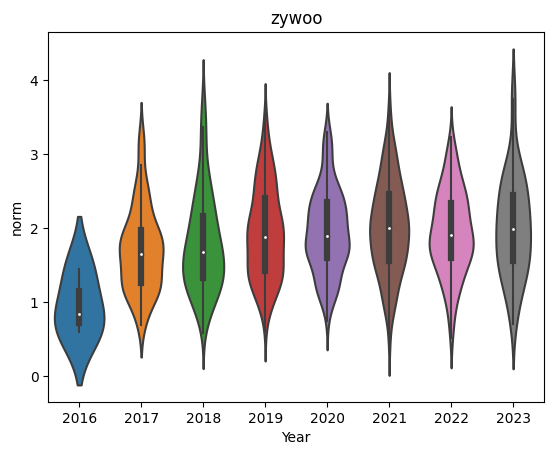

In [136]:
sub_df['Year'] = sub_df['Date'].apply(lambda x: int(x.year))
plt.figure()
sns.violinplot(sub_df[(sub_df['player name'] == focus_players[0])], x='Year', y='norm')
plt.title(focus_players[0])

As you can see, zywoo appears to have a general upwards trend, reinforcing the idea that his public perception of being at the top of his game is accurate.

### Regression
To better demonstrate this trend, let's fit a polynomial regression to his data, and do the same for our seven other players.

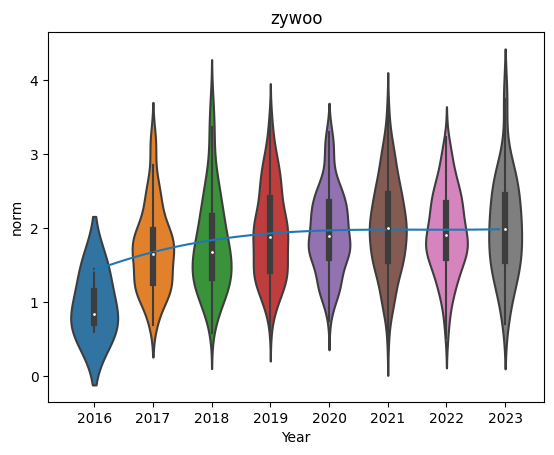

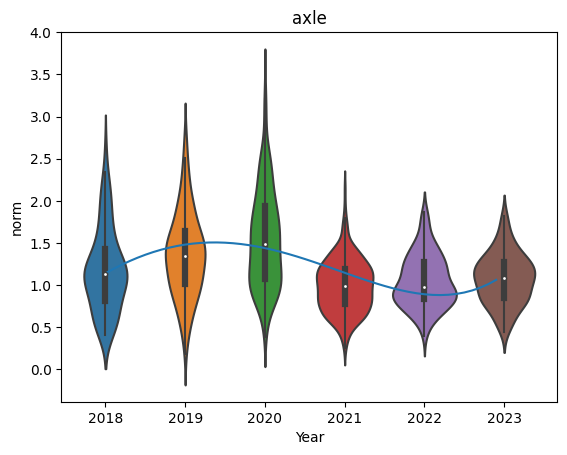

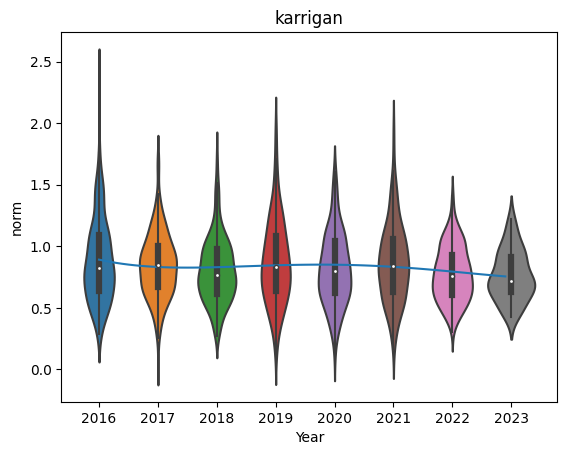

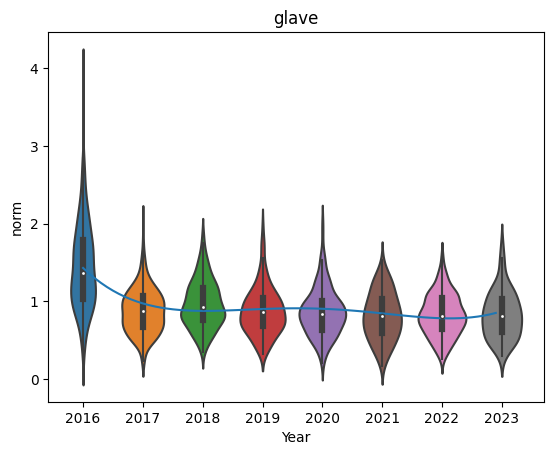

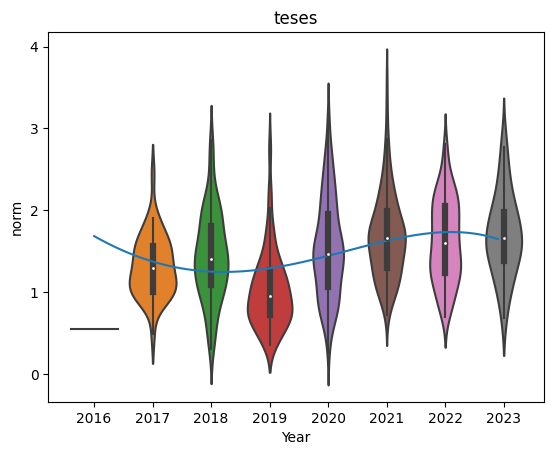

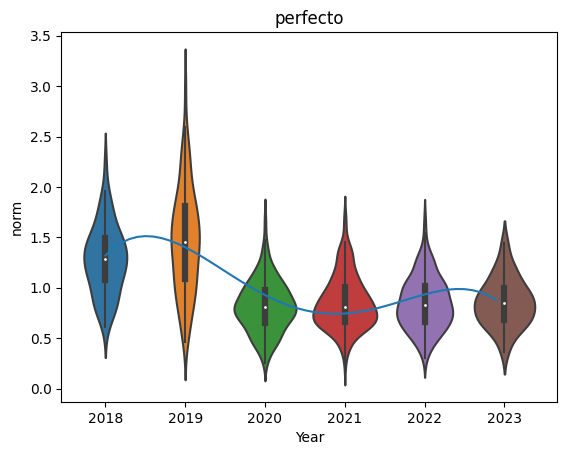

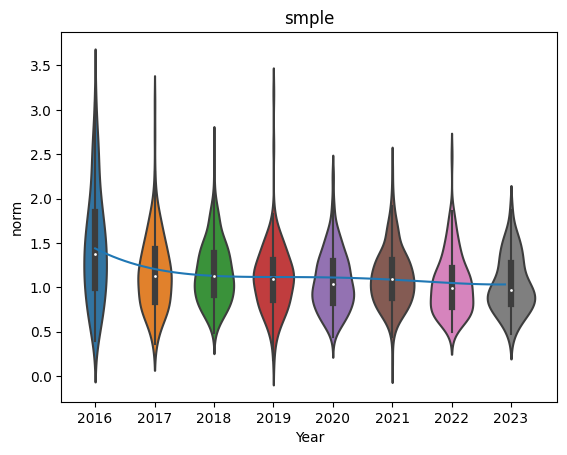

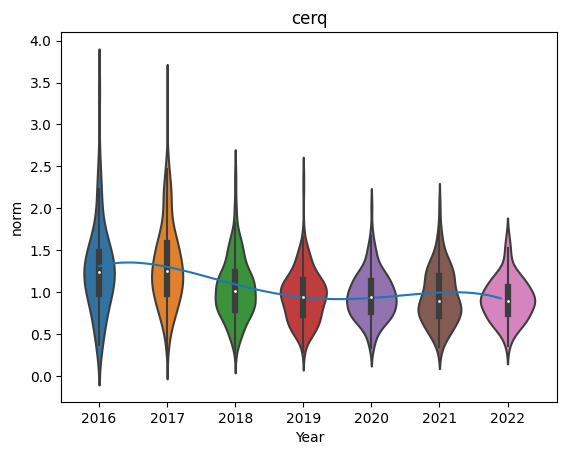

In [137]:
for player in focus_players:
    player_df = sub_df[(sub_df['player name'] == player)].copy()
    player_df['Year2'] = player_df['Year'] - min(player_df['Year'])
    model = ols(formula='norm ~ Year2 + I(Year2 ** 2) + I(Year2 ** 3) + I(Year2 ** 4)', data=player_df).fit()
    plt.figure()
    sns.violinplot(player_df, x='Year', y='norm')
    plt.title(player)
    line = np.poly1d(model.params[::-1])
    x_axis = np.arange(min(player_df['Year2']), max(player_df['Year2']), 0.1)
    sns.lineplot(x=x_axis, y=line(x_axis))

Of our eight players, only zywoo and axle appear to have a strong upwards trend, which matches their public perception of being two of the best players. Karrigan and glave on the other hand appear to not only have much lower normalized ratings overall, but to have general downward trends, indicating their public perception is also consistent with their performance. Teses has pretty good ratings, but lacks a consistent trend, while perfecto has a somewhat downwards trend, which makes sense for mid level players but is not as definite. Their data is similar to that of smple and cerq, who have good ratings but have general downward trends. It is not clear what distinguishes them in public opinion from teses and perfecto to make them considered have-beens instead of mid-level players.

### Role Visualization
Plotting the average rating for all pro players, AWPers only, and riflers only, is very important to understand the importance of data standardization. If we are to compare the performance of players across time, then comparing their nominal rating is not a good way to accurately assess whether one player is better than another. From this plot we can also see the disparity in average rating between AWP and rifle users, so there is clearly a need to standardize across not only time but also the weapon used if we want to compare players regardless of weapon choice.

Text(0.5, 1.0, 'Average rating each half year')

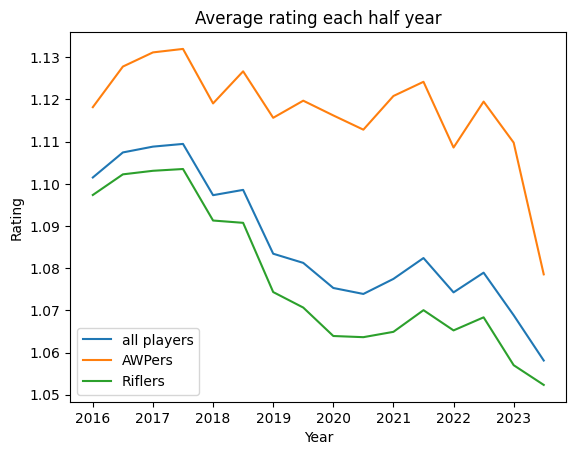

In [138]:
halfyearsx = np.arange(2012, 2024, 0.5)

plt.plot(halfyearsx,y,label = 'all players')
plt.plot(halfyearsx,y_awp,label = 'AWPers')
plt.plot(halfyearsx,y_rifle,label = 'Riflers')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average rating each half year")

If we want to compare players across roles, then we will need to plot their standardized rating to accurately judge how they perform over time and compared to AWPers and riflers.

Text(0.5, 1.0, 'Average semi-yearly standardized rating')

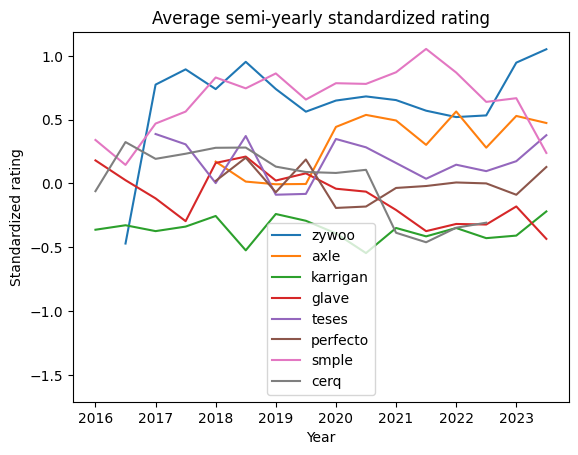

In [139]:
notable_players = ['zywoo','axle','karrigan','glave','teses','perfecto','smple','cerq']
df = df.sort_values('Date')

for i in range(len(notable_players)):
    y = []
    for year in x:
        for step in np.arange(2):
            date_mask = (dt.datetime(year,1 + 5*step,1) < df['Date']) & (df['Date'] < dt.datetime(year,6 + 6*step,30 + 1*step))
            y.append(df[date_mask & (df['player name'] == notable_players[i])]['standard rating'].mean())
            
    plt.plot(halfyearsx, y, label = notable_players[i])

plt.legend()
plt.xlabel("Year")
plt.ylabel("Standardized rating")
plt.title("Average semi-yearly standardized rating")

From an initial visual analysis of the plot, it's clear that from this sample of pro CS:GO players that public opinion is fairly accurate. zywoo and axle are among the top players and on the rise, and cerq and s1mple definitely seem to be past their peaks. However, if we want to do a more rigorous analysis of each player's performance, then we need to some regression analysis. We created a quartic regression fitting to the players' performances and then plotted them against a scatterplot of their average performance in half year increments.

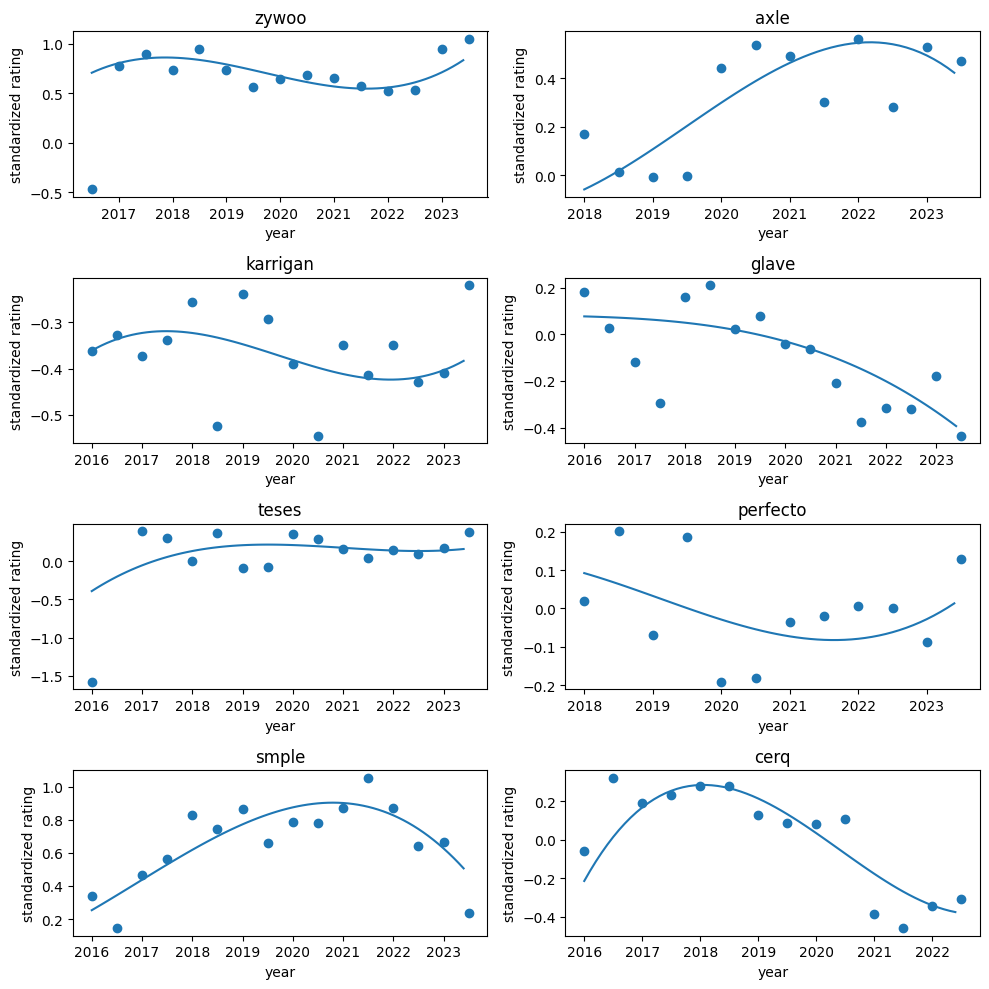

In [140]:
fig = plt.figure(figsize=(10,10))
warnings.simplefilter('ignore', np.RankWarning)

for i in range(len(notable_players)):
    ax = fig.add_subplot(int(len(notable_players)/2),2,i+1)
    y = []
    for year in x:
        for step in np.arange(2):
            date_mask = (dt.datetime(year,1 + 5*step,1) < df['Date']) & (df['Date'] < dt.datetime(year,6 + 6*step,30 + 1*step))
            y.append(df[date_mask & (df['player name'] == notable_players[i])]['standard rating'].mean())
    
    # cleaning NaN from arrays
    cleanedx = []
    cleanedy = []
    for j in range(len(halfyearsx)):
        if not np.isnan(y[j]):
            cleanedx.append(halfyearsx[j])
            cleanedy.append(y[j])
    ax.scatter(halfyearsx, y)
    dates = []
    for date in df[df['player name'] == notable_players[i]]['Date']:
        delta = date - pd.to_datetime('1/1/2000')
        dates.append(delta.days / 365.25 + 2000)
    model = np.poly1d(np.polyfit(dates,df[df['player name'] == notable_players[i]]['standard rating'],4))
    ax.plot(np.arange(cleanedx[0], cleanedx[-1], 0.1), model(np.arange(cleanedx[0], cleanedx[-1], 0.1)))
    plt.xlabel('year')
    plt.ylabel('standardized rating')
    plt.tight_layout()
    plt.title(notable_players[i])


From these regressions, it's clear that zywoo is very high performing with a standardized rating of nearly 1 and has an upward trajectory in rating. Karrigan and gla1ve have predictably poor standardized rating of less than 0, and teses and perfecto are very middling. These regressions all agree with the public opinion of the players. For the players who are viewed as past their prime, cerq is certainly past his peak and now performs worse than the average pro player at -0.2. S1mple is also considered to be on a downwards trend, but with this regression his performance in the past couple years is quite similiar to that of ax1le in terms of rating and trend. Both of these players had their peak within the past year or two and currently perform around 0.5 standardized rating. S1mple is even slightly higher performing than ax1le, so it seems public opinion isn't totally accurate for these two.

## <center> Additional Hypothesis Testing and Analysis

Here in order to help quantify how good player performance is, we look at how well corellated a player's rating is with winning rounds. A common criticism in CS:GO professional games is that certain players, like BlameF, play in a way that benefits themselves but not their teammates, something called "baiting".  An example of this might mean intentionally letting an opposing team win a round at the cost of picking up several kills for yourself.

In order to quantify this, we can look at the relationship between a player's individual performance and their team's. We do this by looking at each player individually, and plotting how many more rounds their team won over the opponent vs their individual performance. By fitting a line and looking at the r-value we can see how much their individual rating affects the team.  If players like BlameF actually bait, then they should have many games where they do well but their teams do not

100%|██████████| 839/839 [00:29<00:00, 28.79it/s]


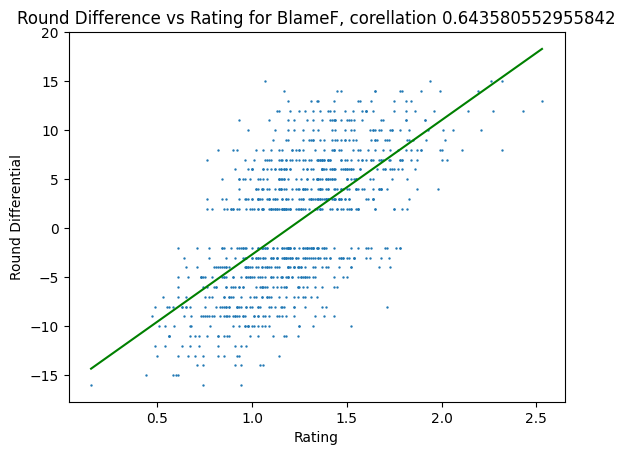

In [153]:
win_correlation = {}
subset = df
players = subset["player name"].unique()
for player in tqdm(players):
    filtered = subset[subset["player name"] == player]
    try:
        slope, intercept, r_value, p_value, std_err = linregress(filtered["rating"], filtered["round difference"])
        win_correlation[player] = r_value
        if "blamef" in str(player):
            plt.scatter(filtered["rating"], filtered["round difference"], s=0.5)
            plt.title("Round Difference vs Rating for BlameF, corellation {}".format(r_value))
            plt.xlabel("Rating")
            plt.ylabel("Round Differential")
            domain = np.linspace(min(filtered["rating"]),max(filtered["rating"]))
            plt.plot(domain, slope * domain + intercept, color='green')
    except:
        ...
plt.show()


From the above plot and linear fit, we see that BlameF has a correlation of 0.643, in order to see how this compares with other players, we can look at a histogram and determine BlameF's corresponding z-score to see if it is statistically different.

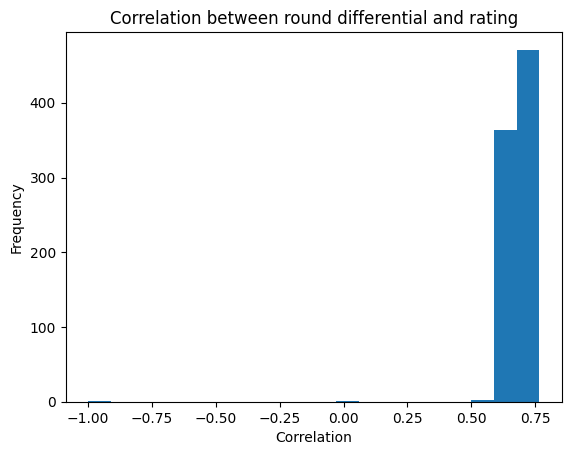

BlameF's z-score: -0.524504791359228
Zywoo's z-score: -0.2613573293025157


In [155]:
standard = (np.array(list(win_correlation.values()))-np.mean(list(win_correlation.values())))/np.std(list(win_correlation.values()))
standard_correl = dict(zip(win_correlation.keys(), standard))

plt.hist(win_correlation.values(), bins=20)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Correlation between round differential and rating")
plt.show()

mean = np.mean(list(win_correlation.values()))
sd = np.std(list(win_correlation.values()))
print("BlameF's z-score: {}".format((win_correlation['blamef']-mean)/sd))
print("Zywoo's z-score: {}".format((win_correlation['zywoo']-mean)/sd))

Looking at BlameF's z-score we see that it is -1.29 standard deviations from 0, corresponding to a p-value of 0.0985.  This means that there is a 10% chance that BlameF's correlation is statistically lower than other players, so we reject the null hypothesis that there is no correlation and conclude that he does indeed bait.


## <center> Conclusion
So to our original question: is public opinion a good representation of pro CS:GO player performance? We have made several models for describing and predicting pro player behavior and performance and our findings for the most part agree with public opinion. It seems the collective public is a fairly good judge at determining whether a player is at the top of their game or past their prime. However, it also appears true that the public can exaggerate the severity with which a player's performance changes. S1mple has definitely seen his best days behind him, but he is still a very highly performing player. His decline is real, but perhaps not quite to the extent that viewers may think. We found that the idea of "baiting" is something that can be quantified and our findings for BlameF agree with the public opinion that he baits. Players like BlameF who bait have low correlations between individual performance and the likelihood of a team's victory. It is important to remember that individual performance is not the sole metric by which a team is measured. As mentioned in our introduction comparing teams Vitality and Heroic, while star players can heavily swing the direction of a match, CS:GO is ultimately a team game. 

Our project is necessarily limited in its scope, and there are many other avenues to explore using these techniques and data. This tutorial serves as an introduction into data science using a topic that is engaging for a younger audience and showcases a variety of data science concepts and approaches.